In [1]:
#!pip install gluoncv==0.10.5.post0

In [2]:
import mxnet as mx
from mxnet import image, gluon
from mxnet.gluon.data.vision import transforms
import gluoncv
import time

ctx = mx.cpu(0)

In [3]:
url = 'https://cdn.pixabay.com/photo/2019/05/23/19/29/dog-4224638_1280.jpg'
filename = 'dog.jpg'
gluoncv.utils.download(url, filename, True)

163KB [00:00, 38389.10KB/s]            


'dog.jpg'

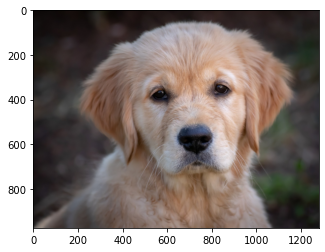

In [4]:
img = image.imread(filename)

from matplotlib import pyplot as plt
plt.imshow(img.asnumpy())
plt.show()

In [5]:
type(img), img.shape

(mxnet.ndarray.ndarray.NDArray, (975, 1280, 3))

In [6]:
type(mx.nd.array(img.asnumpy()))

mxnet.ndarray.ndarray.NDArray

In [7]:
from gluoncv.data.transforms.presets.imagenet import transform_eval
img = transform_eval(img)
type(img), img.shape

[2022-11-09 19:07:38.867 ip-172-16-64-156:10131 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-11-09 19:07:38.888 ip-172-16-64-156:10131 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


(mxnet.ndarray.ndarray.NDArray, (1, 3, 224, 224))

In [8]:
from gluoncv.utils import export_block
net = gluoncv.model_zoo.get_model('resnet18_v1', pretrained=True)
export_block('model', net, preprocess=False, layout='CHW')
print('Done.')

Done.


In [9]:
labels = open('./code/classes_imagenet.txt', 'r')
labels = [c.strip() for c in labels.readlines()]

In [10]:
model = gluon.SymbolBlock.imports(
        "model-symbol.json",
        ["data"],
        "model-0000.params",
        ctx=ctx,
    )
model.labels = labels

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:1454: UserWarning: Cannot decide type for the following arguments. Consider providing them as input:
	data: None
  input_sym_arg_type = in_param.infer_type()[0]


In [11]:
output = model(img)

In [12]:
from mxnet import nd
pred = mx.nd.array(output[0])[None]

topK = 5
ind = nd.topk(pred, k=topK)[0].astype('int')
{model.labels[ind[i].asscalar()]: nd.softmax(pred)[0][ind[i]].asscalar() for i in range(topK)}

{'golden retriever': 0.982643,
 'Labrador retriever': 0.011362792,
 'Tibetan mastiff': 0.0022383432,
 'kuvasz': 0.0014052554,
 'Great Pyrenees': 0.001018399}

In [16]:
import boto3, sagemaker

region = "eu-west-1"
sm_client = boto3.client(service_name="sagemaker", region_name=region)
runtime_sm_client = boto3.client("sagemaker-runtime", region_name=region)
session = sagemaker.Session(boto_session=boto3.Session(region_name=region))
role = "arn:aws:iam::257446244580:role/sagemaker-icevision"

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [17]:
default_bucket = session.default_bucket()
print(default_bucket)

sagemaker-eu-west-1-257446244580


In [18]:
import os
import json
import tarfile

tar = tarfile.open("model.tar.gz", "w:gz")
tar.add("model-0000.params")
tar.add("model-symbol.json")
tar.close()

In [19]:
model_uri = session.upload_data(path="./model.tar.gz", key_prefix="neo_mxnet")
print(model_uri)

s3://sagemaker-eu-west-1-257446244580/neo_mxnet/model.tar.gz


In [20]:
from sagemaker.mxnet.model import MXNetModel

estimator = MXNetModel(model_data="s3://sagemaker-eu-west-1-257446244580/neo_mxnet/model.tar.gz", 
                       role="arn:aws:iam::257446244580:role/sagemaker-icevision", 
                       entry_point="serve_inf1.py", 
                       framework_version='1.7.0',
                       source_dir="./code", 
                       py_version='py3')

In [21]:
estimator = estimator.compile(
    target_instance_family="ml_inf1",
    input_shape={"data": [1, 3, 224, 224]},
    role=role,
    framework="mxnet",
    framework_version="1.7.0",
    job_name=f"neo-mxnet-{int(time.time())}",
    output_path="s3://sagemaker-eu-west-1-257446244580/neo_mxnet/",
)

???????????????????????????....................................................!

In [22]:
# from sagemaker.local import LocalSession

# sagemaker_session = LocalSession()
# sagemaker_session.config = {'local': {'local_code': True}}

In [23]:
from sagemaker.serializers import NumpySerializer

#"ml.c5.4xlarge", #"ml.inf1.xlarge", #"ml.g4dn.xlarge", #'ml.m4.xlarge', 'ml.p3.2xlarge'

mxnet_predictor = estimator.deploy(initial_instance_count=1, 
                                   instance_type='ml.inf1.xlarge',
                                   endpoint_name="mxnet-endpoint",
                                   serializer=NumpySerializer(),)

-------------!

In [24]:
img = image.imread(filename)

In [25]:
type(img), img.shape, img.asnumpy().shape, type(img.asnumpy())

(mxnet.ndarray.ndarray.NDArray, (975, 1280, 3), (975, 1280, 3), numpy.ndarray)

In [27]:
response = mxnet_predictor.predict(img.asnumpy())

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "array::at
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 140, in transform
    self._transform_fn, *(self._model, input_data, content_type, accept)
  File "/usr/local/lib/python3.6/site-packages/sagemaker_inference/transformer.py", line 266, in _run_handler_function
    result = func(*argv)
  File "/opt/ml/model/code/serve_inf1.py", line 78, in transform_fn
    pred = model.get_outputs()[0].asnumpy()
  File "/usr/local/lib/python3.6/site-packages/mxnet/ndarray/ndarray.py", line 1996, in asnumpy
    ctypes.c_size_t(data.size)))
  File "/usr/local/lib/python3.6/site-packages/mxnet/base.py", line 253, in check_call
    raise MXNetError(py_str(_LIB.MXGetLastError()))
mxnet.base.MXNetError: array::at
". See https://eu-west-1.console.aws.amazon.com/cloudwatch/home?region=eu-west-1#logEventViewer:group=/aws/sagemaker/Endpoints/mxnet-endpoint in account 257446244580 for more information.

In [ ]:
response

In [ ]:
#%%timeit
#cpu 109ms c5
#gpu 77ms g4

#cpu NEO 101ms c5
#gpu NEO 81ms p3
#_ = mxnet_predictor.predict(img.asnumpy())

In [28]:
# mxnet_predictor.delete_model()
# mxnet_predictor.delete_endpoint()